In [67]:
from typing import Callable, Tuple
from IPython.core.display_functions import display
from scipy import rand
from sklearn.datasets import make_classification, make_moons, make_blobs, make_circles, make_s_curve
import numpy as np
import seaborn as sns
from numpy import ndarray
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from scipy.optimize import minimize, LinearConstraint, Bounds, BFGS
plt.rcParams["figure.figsize"] = (20,10)
ZERO = 1e-5
random_state = 244827
n_samples = 2427

In [2]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])
        self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.05, random_state=random_state)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.small_x_train[:, i] = (self.small_x_train[:, i] - x_min) / (x_max - x_min)
                self.small_x_train[:, i] = self.small_x_train[:, i] * (max_v - min_v) + min_v

                self.big_x_train[:, i] = (self.big_x_train[:, i] - x_min) / (x_max - x_min)
                self.big_x_train[:, i] = self.big_x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
                self.small_x_train[:, i] = 1
                self.big_x_train[:, i] = 1

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
            self.big_y_train[self.big_y_train == o] = n
            self.small_y_train[self.small_y_train == o] = n

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

In [3]:
# def _lagrange_function(self, alpha, x, y):
#     res = np.zeros((alpha.shape[0], alpha.shape[0]))
#     for i in range(alpha.shape[0]):
#         res[i] = np.dot(alpha, alpha[i]) * np.dot(y, y[i]) * self.kernel_function(x, x[i, :], self.degree, self.gamma)


class MySVM:
    _sparse_kernels = ['linear', 'poly', 'rbf']

    @staticmethod
    def _linear_kernel(x1, x2, *args):
        return np.dot(x1, x2)

    @staticmethod
    def _poly_kernel(x1, x2, *args): # args[0] - degree, args[1] - gamma, args[2] - intercept
        return (args[1] * np.dot(x1, x2) + args[2]) ** args[0]

    @staticmethod
    def _rbf_kernel(x1, x2, *args):  # args[0] - degree, args[1] - gamma, args[2] - intercept
        return np.exp(-args[1] * np.linalg.norm(x1 - x2) ** 2)

    def __init__(self, C=1, kernel='rbf', gamma=0.1, degree=2, random_state=244827):
        if kernel not in self._sparse_kernels:
            raise ValueError(f'kernel {kernel} is not supported')
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.random_state = random_state
        self.kernel_function = {'linear': self._linear_kernel, 'poly': self._poly_kernel, 'rbf': self._rbf_kernel}[kernel]
        self.coef_ = None
        self.intercept_ = None
        self.alpha_ = None
        self.support_ = None
        self.support_vectors_ = None
        self.support_labels = None
        self.train_labels = None
        self.train_vectors_ = None

    def _lagrange_function(self, alpha, x, y):
        res = 0
        for i in range(alpha.shape[0]):
            for j in range(alpha.shape[0]):
                res += alpha[i] * alpha[j] * y[i] * y[j] * self.kernel_function(x[i], x[j], self.degree, self.gamma, 0)

        return  0.5 * res - sum(alpha)

    def fit(self, x_train, y_train):
        n, m = x_train.shape
        # np.random.seed(self.random_state)
        alpha_start = np.random.uniform(0, self.C, size=n)
        # alpha_start = np.zeros(n)
        linear_constraint = LinearConstraint(A=y_train, lb=[0], ub=[0])
        bounds = Bounds(np.zeros(n), np.full(n, self.C-ZERO))
        result = minimize(
            fun=self._lagrange_function,
            x0=alpha_start,
            args=(x_train, y_train),
            # hess=BFGS(),
            constraints=[linear_constraint],
            bounds=bounds)
        self.alpha_ = result.x
        self.alpha_[self.alpha_ < ZERO] = 0
        self.support_ = np.where(self.alpha_ > ZERO)[0]
        self.support_vectors_ = x_train[self.support_]
        self.support_labels = y_train[self.support_]
        self.train_vectors_ = x_train
        self.train_labels = y_train

        self.coef_ = np.zeros(m)
        for i in self.support_:
            self.coef_ += self.alpha_[i] * y_train[i] * x_train[i]

        self.intercept_ = 0
        # c_num = self.C - ZERO
        for i in self.support_:
            self.intercept_ += y_train[i] - np.dot(self.coef_, x_train[i])
        self.intercept_ /= len(self.support_)
        return self

    def decision_function(self, x):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')

        if self.kernel == 'linear':
            return np.dot(x, self.coef_) + self.intercept_

        y_pred = []
        for sample in x:
            pred = 0
            for i in self.support_:
                pred += self.alpha_[i] * self.train_labels[i] * self.kernel_function(sample, self.train_vectors_[i, :], self.degree, self.gamma, self.intercept_)
            y_pred.append(pred)

        return np.array(y_pred)

    def predict(self, x):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')
        return np.sign(self.decision_function(x))


In [4]:
def compare_models(my_model, sk_model, data: PUMData):
    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    Z_an = my_model.decision_function(mesh_data).reshape(xx.shape)
    Z_sk = sk_model.decision_function(mesh_data).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title, model in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model SVC'],
        [my_model, sk_model]):
        axarr[idx].pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
        axarr[idx].contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
        axarr[idx].scatter(data.small_x_train[:, 0], data.small_x_train[:, 1], c=data.small_y_train, s=20, edgecolor="k")
        axarr[idx].scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted, labels=[-1, 1])
    cm_an = confusion_matrix(data.y_test, y_an_predicted, labels=[-1, 1])

    sensitivity_sk = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity_sk = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    sensitivity_an = cm_an[1, 1] / (cm_an[1, 0] + cm_an[1, 1])
    specifity_an = cm_an[0, 0] / (cm_an[0, 0] + cm_an[0, 1])

    print(f'Model własny: Czulość: {sensitivity_an}, swoistość: {specifity_an}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_an_predicted, adjusted=True)}')
    print(f'Model sklearn: Czulość: {sensitivity_sk}, swoistość: {specifity_sk}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_sk_predicted, adjusted=True)}')

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model SVC']
    ):
        sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
        axarr[idx].set_title(title)

    plt.show()

    my_function = my_model.decision_function(data.x_test)
    sk_function = sk_model.decision_function(data.x_test)

    fpr, tpr, thresholds = roc_curve(data.y_test, my_function)
    plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, my_function):.3f}')
    fpr, tpr, thresholds = roc_curve(data.y_test, sk_function)
    plt.plot(fpr, tpr, label=f'sklearn model, AUC={roc_auc_score(data.y_test, sk_function):.3f}')
    plt.legend()
    plt.show()

In [5]:
data_linear = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)
data_linear.change_labels([0], [-1])
# data_linear.normalize()

In [6]:
my_model = MySVM(C=1, kernel='linear', gamma=0.1, degree=1)
start = time()
my_model.fit(data_linear.small_x_train, data_linear.small_y_train)
print(f'Time: {time() - start}')

Time: 30.98616337776184


In [7]:
sk_model = SVC(C=1, kernel='linear', gamma=0.1, degree=1, random_state=random_state)
sk_model.fit(data_linear.small_x_train, data_linear.small_y_train)

SVC(C=1, degree=1, gamma=0.1, kernel='linear', random_state=244827)

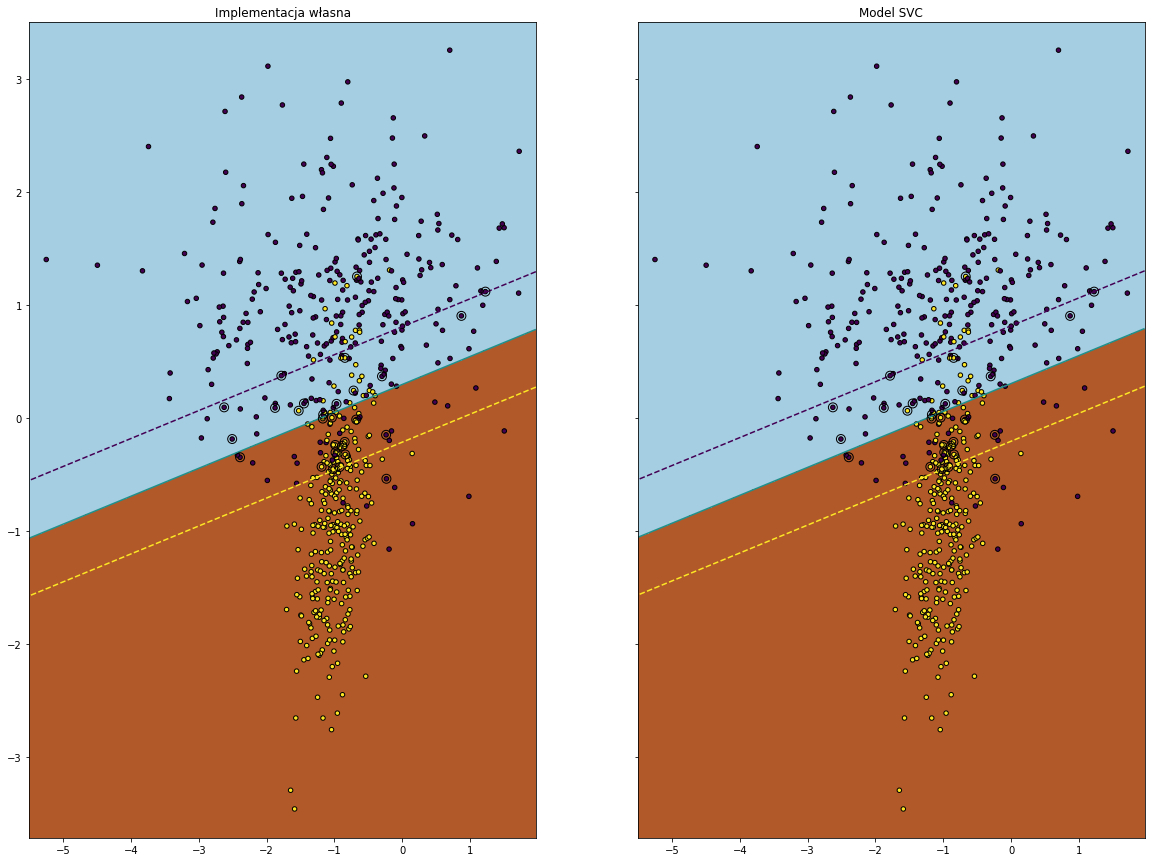

Model własny: Czulość: 0.8975409836065574, swoistość: 0.8842975206611571, Adjusted accuracy=0.7818385042677145
Model sklearn: Czulość: 0.8975409836065574, swoistość: 0.8801652892561983, Adjusted accuracy=0.7777062728627557


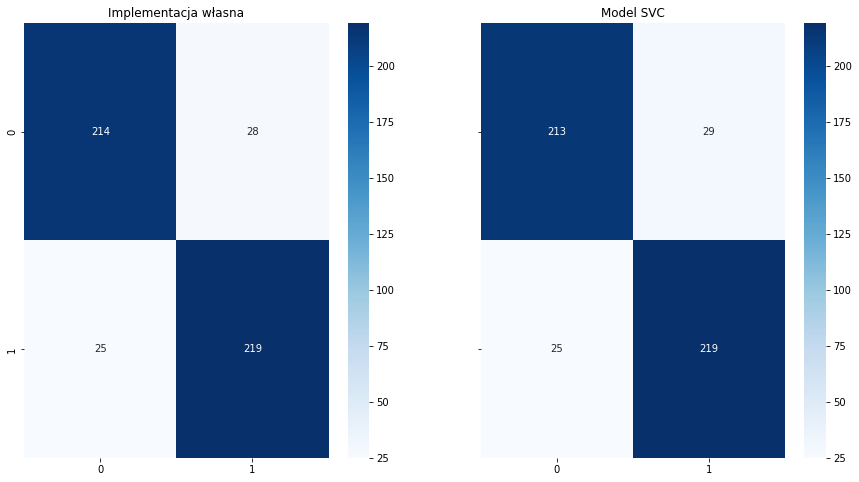

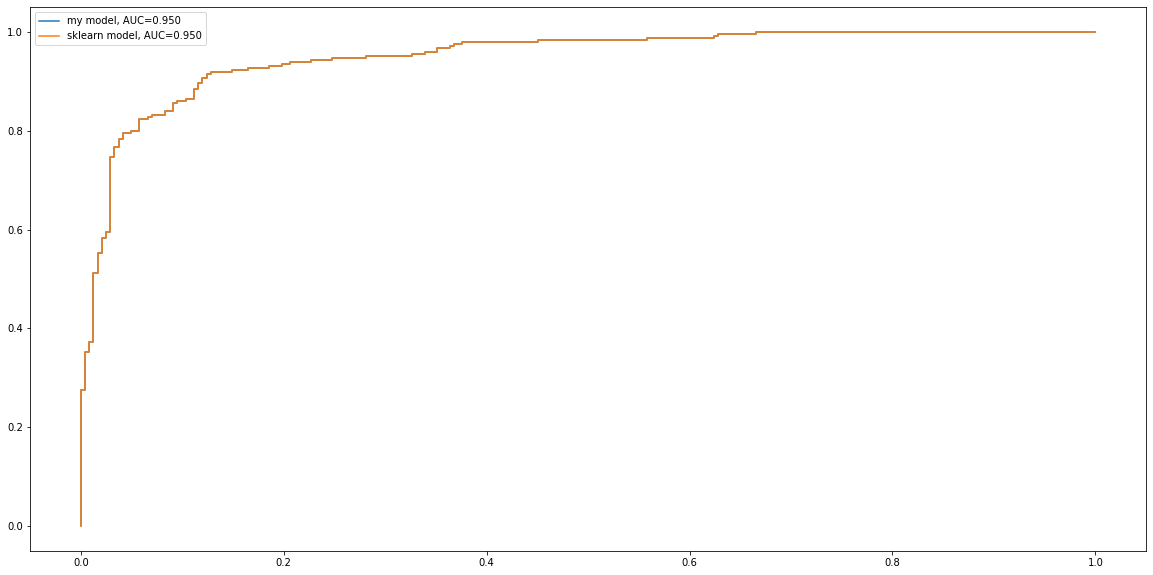

In [8]:
compare_models(my_model, sk_model, data_linear)

In [9]:
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.1, random_state=random_state), random_state=random_state)
data_moons.change_labels([0], [-1])
# data_moons.normalize()

In [10]:
my_model_poly = MySVM(C=1, kernel='poly', degree=3, gamma=0.75)
start = time()
my_model_poly.fit(data_moons.small_x_train, data_moons.small_y_train)
training_time = time() - start
print(f'Training time: {training_time}')

Training time: 44.282944202423096


In [11]:
sk_model_poly = SVC(C=1, kernel='poly', degree=3, gamma=0.75)
sk_model_poly.fit(data_moons.small_x_train, data_moons.small_y_train)

SVC(C=1, gamma=0.75, kernel='poly')

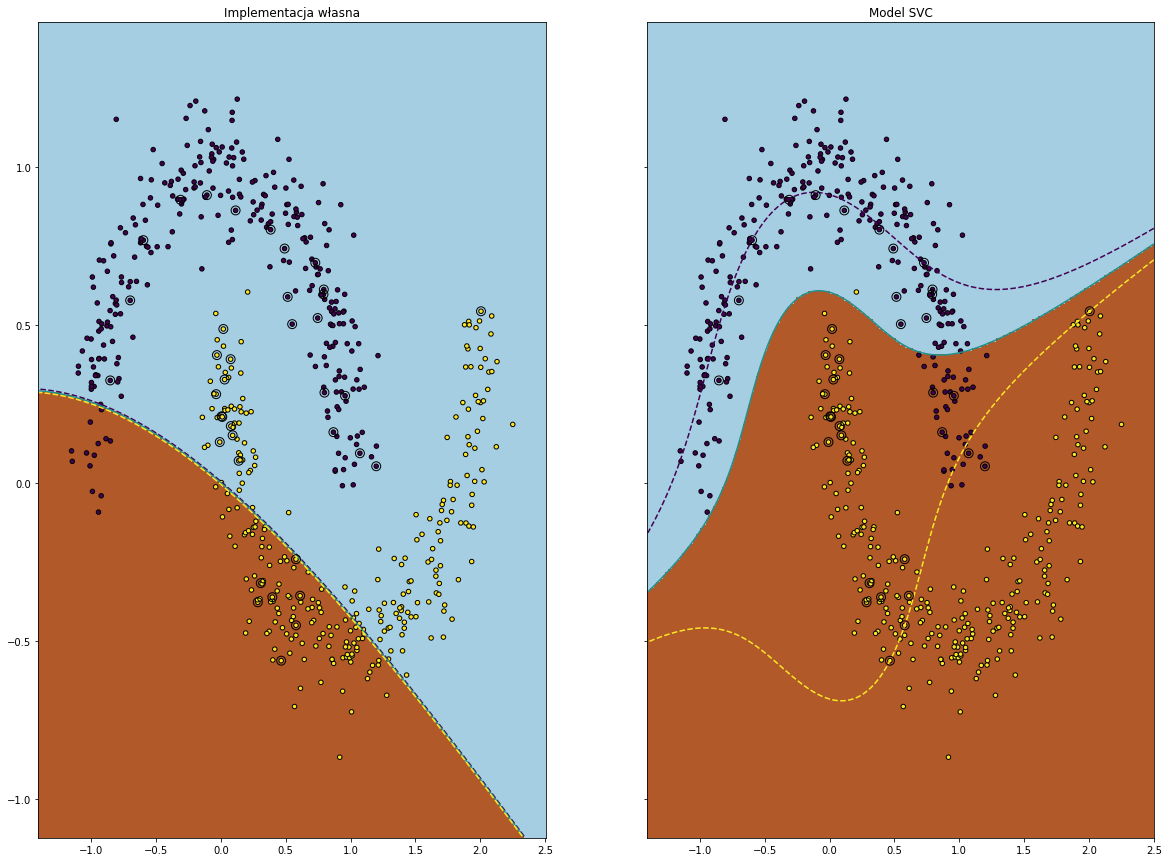

Model własny: Czulość: 0.4156378600823045, swoistość: 0.9465020576131687, Adjusted accuracy=0.3621399176954734
Model sklearn: Czulość: 0.9958847736625515, swoistość: 0.8477366255144033, Adjusted accuracy=0.8436213991769548


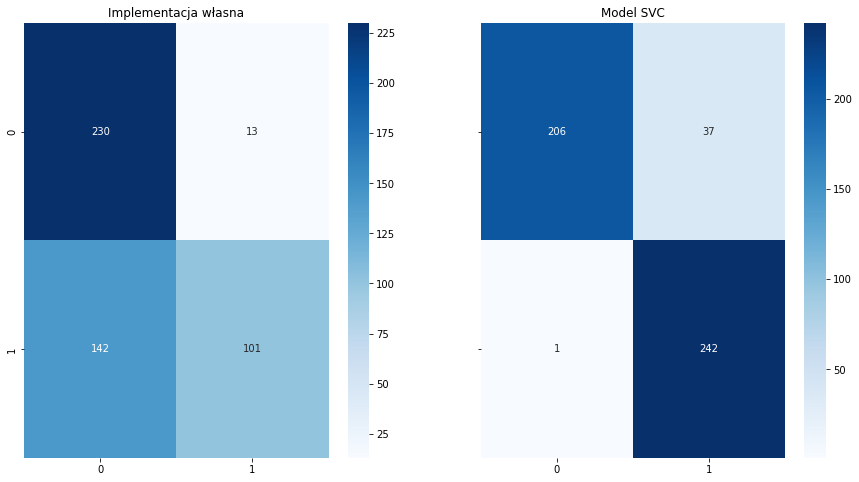

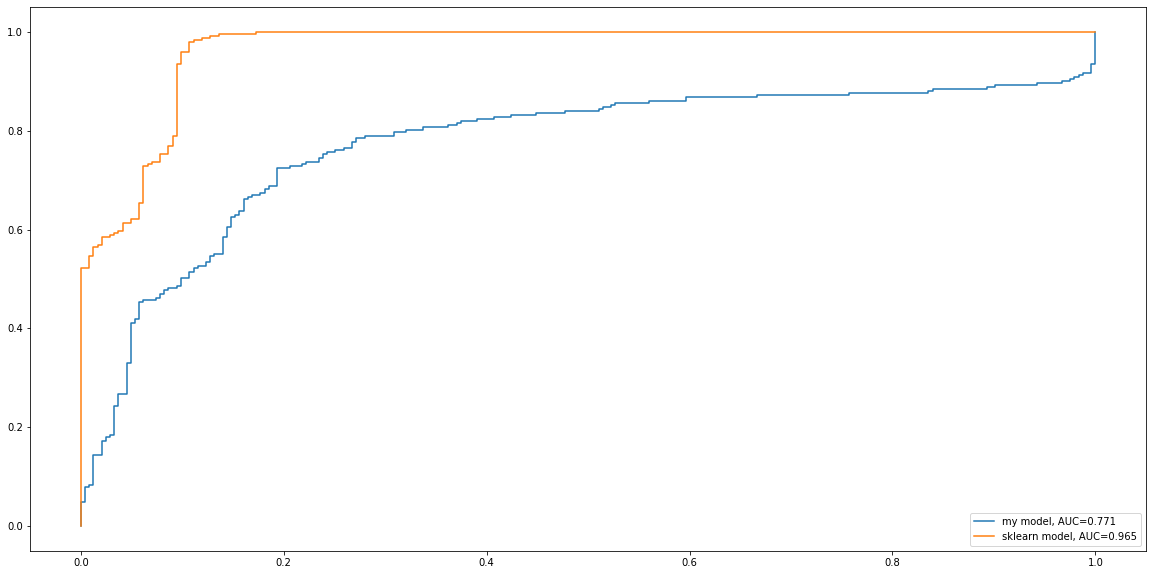

In [12]:
compare_models(my_model_poly, sk_model_poly, data_moons)

In [13]:
my_model_rbf = MySVM(C=1, kernel='rbf', gamma=0.75)
start = time()
my_model_rbf.fit(data_moons.small_x_train, data_moons.small_y_train)
training_time = time() - start
print(f'Training time: {training_time}')

Training time: 221.72985649108887


In [14]:
sk_model_rbf = SVC(C=1, kernel='rbf', gamma=0.75)
sk_model_rbf.fit(data_moons.small_x_train, data_moons.small_y_train)

SVC(C=1, gamma=0.75)

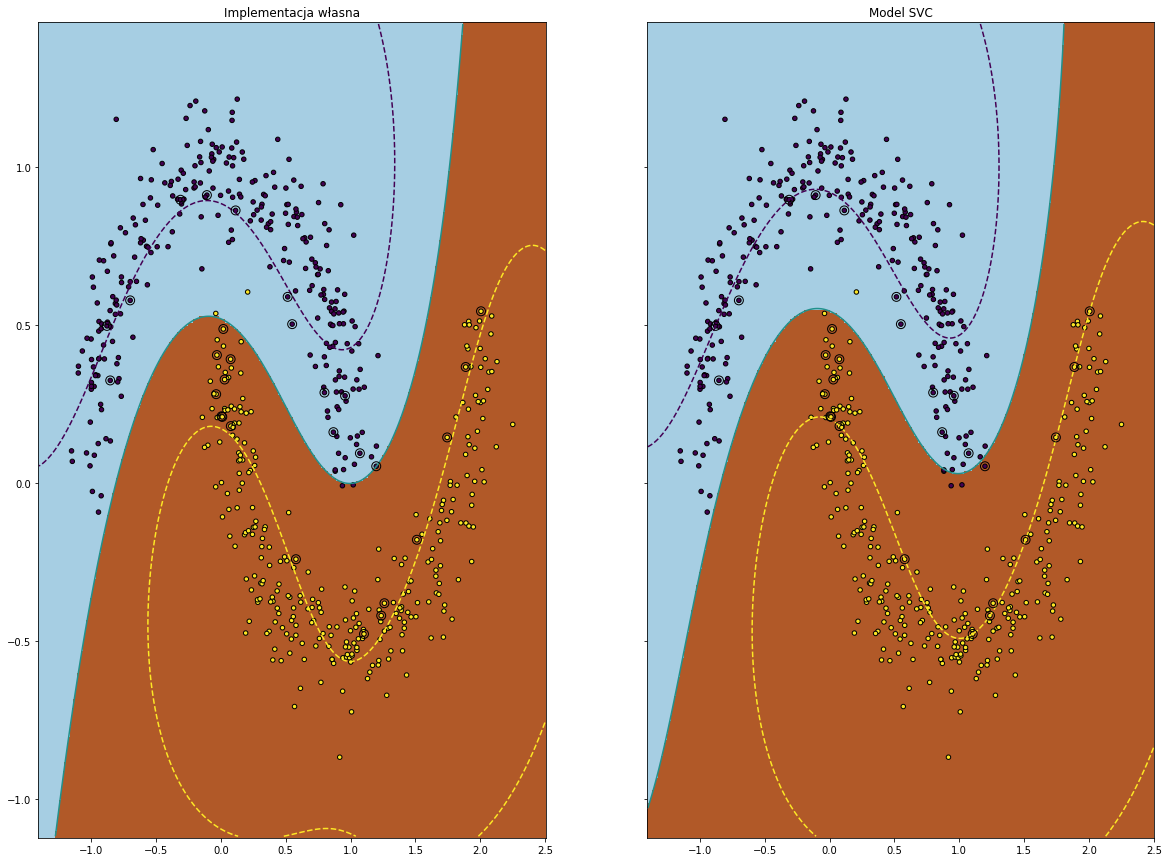

Model własny: Czulość: 0.9917695473251029, swoistość: 0.9917695473251029, Adjusted accuracy=0.9835390946502058
Model sklearn: Czulość: 0.9958847736625515, swoistość: 0.9835390946502057, Adjusted accuracy=0.9794238683127572


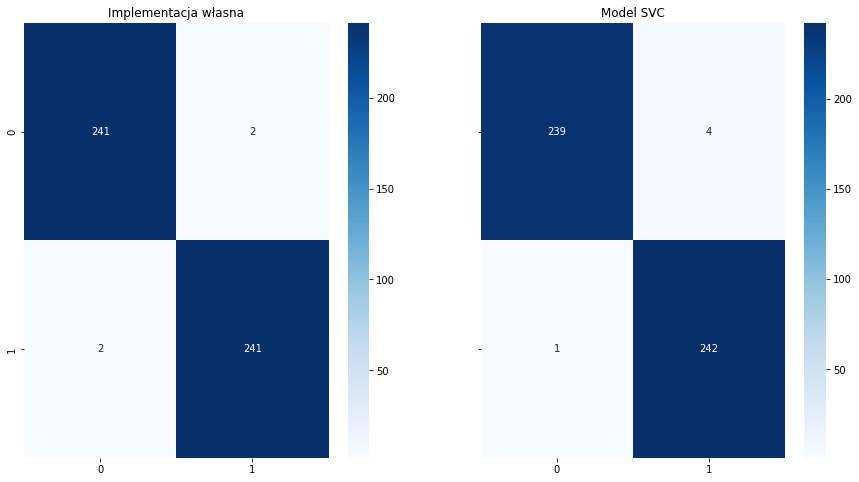

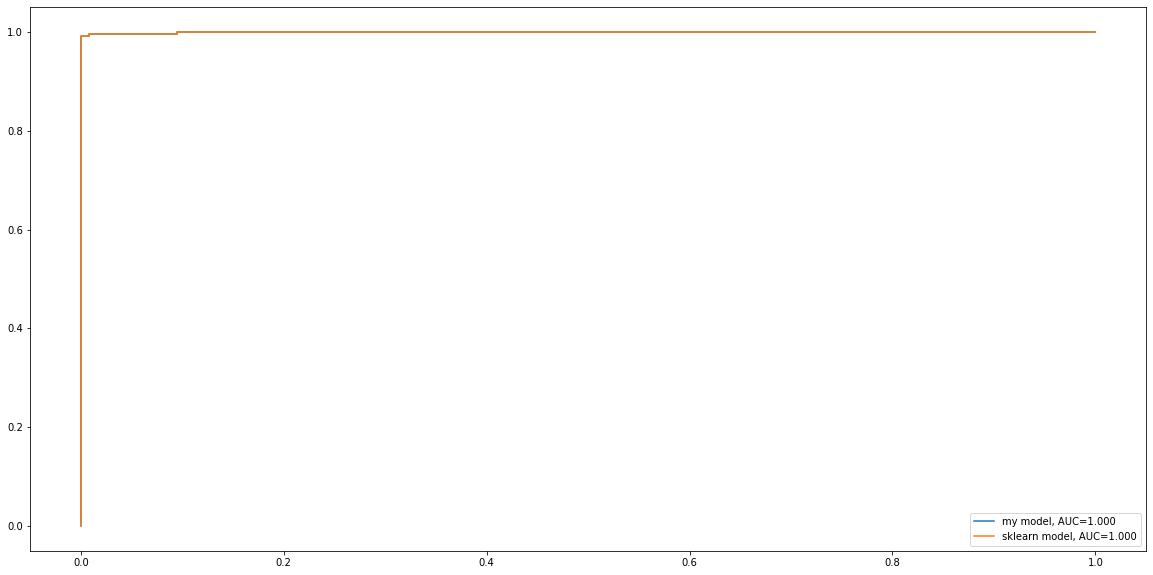

In [15]:
compare_models(my_model_rbf, sk_model_rbf, data_moons)

## Czesc 3

In [85]:
raw_data = pd.read_csv('star_classification_SDSS17.csv')
# raw_data.head(15)

In [86]:
raw_data = raw_data.dropna(subset=['class'])
raw_data = raw_data[raw_data['class'] != 'QSO']
raw_data.loc[ raw_data['class'] == 'GALAXY', 'class'] = -1
raw_data.loc[ raw_data['class'] == 'STAR', 'class'] = 1
raw_data['class'] = raw_data['class'].astype(int)
for column in raw_data.columns:
    raw_data[column] = pd.to_numeric(raw_data[column], errors='coerce')
    if column.endswith('_ID'):
        raw_data = raw_data.drop(column, axis=1)
raw_data = raw_data.drop(['cam_col'], axis=1)
raw_data = raw_data.drop(['MJD'], axis=1)
raw_data.head(10)

,alpha,delta,u,g,r,i,z,class,redshift,plate
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,-1,0.634794,5812
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,-1,0.779136,10445
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,-1,0.644195,4576
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,-1,0.932346,9149
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,-1,0.116123,6121
7,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,-1,0.477009,6183
8,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,-1,0.660012,6625
9,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,1,-0.000008,2444
10,328.092076,18.220310,25.77163,22.52042,20.63884,19.78071,19.05765,-1,0.459596,5020
11,243.986637,25.738280,23.76761,23.79969,20.98318,19.80745,19.45579,-1,0.591409,4727


In [87]:
temp = raw_data.median(axis=0, numeric_only=True)

for index, value in temp.items():
    raw_data[index].fillna(value, inplace=True)

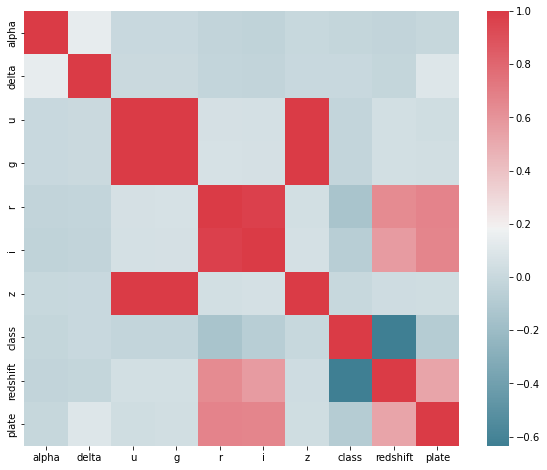

alpha      -0.017150
delta      -0.000346
u          -0.023778
g          -0.021976
r          -0.147360
i          -0.078462
z          -0.007263
class       1.000000
redshift   -0.634963
plate      -0.090946
Name: class, dtype: float64


In [88]:
f, ax = plt.subplots(figsize=(10, 8))
corr = raw_data.corr()

sns.heatmap(corr, mask=np.zeros_like(corr),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()
print(corr['class'])

In [95]:
np_labels = raw_data['class'].to_numpy()
np_data = raw_data.drop(['class'], axis=1).to_numpy()
astro_data = PUMData((np_data, np_labels), random_state=random_state)
astro_data.winsorize()
astro_data.normalize()

In [96]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10]}
svc = SVC()
grid_searcher = GridSearchCV(svc, parameters, n_jobs=4)

In [97]:
grid_searcher.fit(astro_data.x_train, astro_data.y_train)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'rbf')})

In [101]:
print(grid_searcher.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [98]:
best_model = grid_searcher.best_estimator_

In [99]:
def evaluate_mulit_feature_model(model, data, cm_labels=[-1, 1]):
    y_predicted = model.predict(data.x_test)

    cm = confusion_matrix(data.y_test, y_predicted, labels=cm_labels)

    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specifity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    print(f'Metryki modelu: Czulość: {sensitivity}, swoistość: {specifity}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_predicted, adjusted=True)}')

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title('Macierz pomyłek')
    plt.show()

    decision_fun = model.decision_function(data.x_test)

    fpr, tpr, thresholds = roc_curve(data.y_test, decision_fun)
    plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, decision_fun):.3f}')
    plt.legend()
    plt.show()

Metryki modelu: Czulość: 0.9997684649224358, swoistość: 0.9886449659348978, Adjusted accuracy=0.9884134308573336


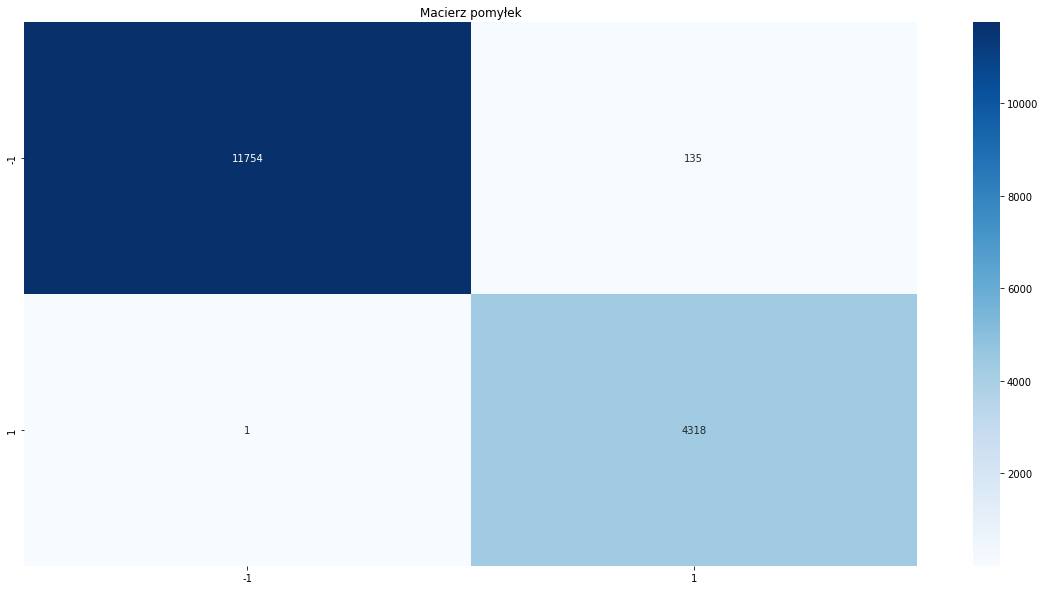

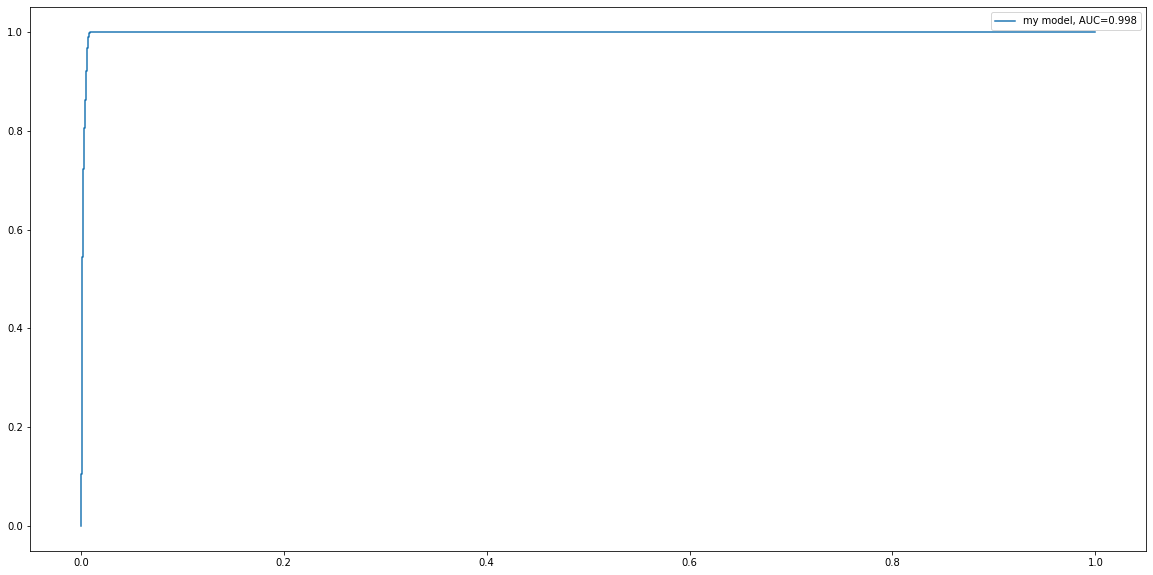

In [100]:
evaluate_mulit_feature_model(best_model, astro_data)